In [ ]:
Using full dataset

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [81]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
from glob import glob
import tables as tb
import tqdm


import multiprocessing as mp

In [3]:
import sys
sys.path.insert(0, 'code')
from models import *
from v13_deeplab import *

In [4]:
MODEL_NAME = 'v13'
ORIGINAL_SIZE = 650
sz = 256
bs = 200
num_slice = 9
STRIDE_SZ = 197
PATH = 'data/'

BASE_DIR = "data/train"
BASE_TEST_DIR = "data/test"
WORKING_DIR = "data/working"

# Restore later
IMAGE_DIR = "data/working/images/{}".format('v12')
# IMAGE_DIR = "data/working/images/{}".format('v5')
V5_IMAGE_DIR = "data/working/images/{}".format('v5')

# ---------------------------------------------------------
# Parameters
MIN_POLYGON_AREA = 30  # 30

# ---------------------------------------------------------
# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path(BASE_DIR) /
    Path("{prefix:s}_Train/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path(BASE_TEST_DIR) /
    Path("{prefix:s}_Test/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# ---------------------------------------------------------
# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut.csv"

# ---------------------------------------------------------
# Image list, Image container and mask container
FMT_VALTRAIN_IM_FOLDER = V5_IMAGE_DIR + "/trn_full_rgb/"
FMT_VALTEST_IM_FOLDER = V5_IMAGE_DIR + "/test_full_rgb/"

FMT_VALTRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
# FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
# FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTRAIN_MASK_STORE = V5_IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTEST_MASK_STORE = V5_IMAGE_DIR + "/valtest_{}_mask.h5"
# FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"
# FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"
FMT_VALTRAIN_MUL_STORE = V5_IMAGE_DIR + "/valtrain_{}_mul.h5"
FMT_VALTEST_MUL_STORE = V5_IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_TRAIN_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_train_ImageId.csv"
FMT_TEST_IMAGELIST_PATH = V5_IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TRAIN_IM_STORE = IMAGE_DIR + "/train_{}_im.h5"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TRAIN_MASK_STORE = IMAGE_DIR + "/train_{}_mask.h5"
FMT_TRAIN_MUL_STORE = IMAGE_DIR + "/train_{}_mul.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"
FMT_IMMEAN = V5_IMAGE_DIR + "/{}_immean.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

# ---------------------------------------------------------
# Model files
MODEL_DIR = "data/working/models/{}".format(MODEL_NAME)
FMT_VALMODEL_PATH = MODEL_DIR + "/{}_val_weights.h5"
FMT_FULLMODEL_PATH = MODEL_DIR + "/{}_full_weights.h5"
FMT_VALMODEL_HIST = MODEL_DIR + "/{}_val_hist.csv"
FMT_VALMODEL_EVALHIST = MODEL_DIR + "/{}_val_evalhist.csv"
FMT_VALMODEL_EVALTHHIST = MODEL_DIR + "/{}_val_evalhist_th.csv"

# ---------------------------------------------------------
# Prediction & polygon result
FMT_TESTPRED_PATH = MODEL_DIR + "/{}_pred.h5"
FMT_VALTESTPRED_PATH = MODEL_DIR + "/{}_eval_pred.h5"
FMT_VALTESTPOLY_PATH = MODEL_DIR + "/{}_eval_poly.csv"
FMT_VALTESTTRUTH_PATH = MODEL_DIR + "/{}_eval_poly_truth.csv"
FMT_VALTESTPOLY_OVALL_PATH = MODEL_DIR + "/eval_poly.csv"
FMT_VALTESTTRUTH_OVALL_PATH = MODEL_DIR + "/eval_poly_truth.csv"
FMT_TESTPOLY_PATH = MODEL_DIR + "/{}_poly.csv"
FN_SOLUTION_CSV = "data/output/{}.csv".format(MODEL_NAME)

# ---------------------------------------------------------
# Model related files (others)
FMT_VALMODEL_LAST_PATH = MODEL_DIR + "/{}_val_weights_last.h5"
FMT_FULLMODEL_LAST_PATH = MODEL_DIR + "/{}_full_weights_last.h5"

## Preprocessing

In [5]:
# datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
# !python code/v5_im-full_rgb.py preproc_train {datapaths[1]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[3]}

In [7]:
# !python code/v5_im-full_rgb.py preproc_train {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_train {datapaths[2]}

In [8]:
# for d in datapaths: print(d, end=' ')

In [9]:
# !parallel python code/v5_im-full_rgb.py preproc_train {} ::: data/train/AOI_2_Vegas_Train data/train/AOI_3_Paris_Train data/train/AOI_4_Shanghai_Train data/train/AOI_5_Khartoum_Train

In [10]:
# for train_path in ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']:
#     !python code/v12_im_deeplab.py preproc_train {train_path}

### Overload

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [12]:
def get_data(area_id, is_test):
    prefix = area_id_to_prefix(area_id)
    fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) if is_test else FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
    df_train = pd.read_csv(fn_train)
    
    fn_im = FMT_VALTEST_MASK_STORE.format(prefix) if is_test else FMT_VALTRAIN_MASK_STORE.format(prefix)
    y_val = []
    with tb.open_file(fn_im, 'r') as f:
        for image_id in tqdm.tqdm(df_train.ImageId.tolist(), total=df_train.shape[0]):
            fn = '/' + image_id
            im = np.array(f.get_node(fn))[..., None]
            y_val.append(im)
            
    fn_im = FMT_VALTEST_IM_FOLDER if is_test else FMT_VALTRAIN_IM_FOLDER
    X_val = []
    for image_id in tqdm.tqdm(df_train.ImageId.tolist(), total=df_train.shape[0]):
        im = plt.imread(fn_im + image_id + '.png')[...,:3]
#             print(im.shape)
#         im = np.moveaxis(im, -1, 0)
        X_val.append(im)

    X_val, y_val = np.array(X_val).astype('float'), np.array(y_val).astype('float')
    return X_val, y_val

In [13]:
# memory dataset
def get_dataset(datapath):
    area_id = directory_name_to_area_id(datapath)
    prefix = area_id_to_prefix(area_id)
    trn_x, trn_y = get_data(area_id, False)
#     print(trn_x.shape, trn_y.shape)
#     trn_x = np.moveaxis(trn_x, 1, -1).astype('float') # --> [bs, h, w, ch]
#     trn_y = np.moveaxis(trn_y, 1, -1).astype('float')

#     print(trn_x.shape, trn_y.shape)
    trn_y = np.broadcast_to(trn_y, [trn_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])

    val_x, val_y = get_data(area_id, True)
#     val_x = val_x[:,:3]
#     val_x = np.moveaxis(val_x, 1, -1).astype('float')
#     val_y = val_y[:,:3]
#     val_y = np.moveaxis(val_y, 1, -1).astype('float')
    val_y = np.broadcast_to(val_y, [val_y.shape[0], ORIGINAL_SIZE, ORIGINAL_SIZE, 3])
               
    return (trn_x,trn_y), (val_x,val_y)


In [14]:
datapaths = ['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']

In [15]:
(trn_x,trn_y), (val_x,val_y) = get_dataset(datapaths[0])

100%|██████████| 345/345 [00:06<00:00, 54.24it/s]


In [16]:
class ArraysSingleDataset(BaseDataset):
    def __init__(self, x, y, transform):
        # input: ch x w x h
        self.x = x; self.y = y
#         self.num_groups = len(x)
        self.sz = x[0].shape[1]
#         self.ns = np.array([o.shape[0] for o in x])
#         self.cum_ns = np.cumsum(self.ns * num_slice)
        super().__init__(transform)

        
    def get_im(self, i, is_y):
#         idx_file, idx_im = self.get_file_idx(i)
        if is_y:
            im = self.y[i//num_slice]
        else:
            im = self.x[i//num_slice]
#         slice_pos = idx_im % num_slice
#         a = np.sqrt(num_slice)
#         cut_i = slice_pos // a
#         cut_j = slice_pos % a
#         stride = (self.sz - sz) // a
#         cut_x = int(cut_j * stride)
#         cut_y = int(cut_i * stride)
        slice_pos = i % num_slice
        a = np.sqrt(num_slice)
        cut_i = slice_pos // a
        cut_j = slice_pos % a
        stride = (self.sz - sz) // a
        cut_x = int(cut_j * stride)
        cut_y = int(cut_i * stride)
        return im[cut_x:cut_x + sz, cut_y:cut_y + sz]
        
            
    def get_x(self, i): return self.get_im(i, False)
    def get_y(self, i): return self.get_im(i, True)
        
#     def get_file_idx(self, i):
#         idx_file = np.argmax(i + 1 <= self.cum_ns)
#         if idx_file == 0:
#             idx_im = i
#         else:
#             idx_im = i - self.cum_ns[idx_file - 1]
#         return idx_file, idx_im
    
    def get_n(self): return self.x.shape[0] * num_slice
    
    def get_sz(self): return self.sz
        
    def get_c(self): return 1
    def denorm(self, arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
#         return np.clip(self.transform.denorm(np.rollaxis(arr,1,4)), 0, 1)
        return self.transform.denorm(np.rollaxis(arr,1,4))

In [17]:
cut_base = 8
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        c = list(children(self.model.module))
        return [c[:cut_base],
               c[cut_base:]]

In [208]:
def sep_iou(y_pred, y_true, thresh=0.5):
    return np.array([jaccard_coef(p, t) for (p, t) in zip(y_pred, y_true)])
    
def jaccard_coef(y_pred, y_true, thresh=0.5):
    smooth = 1e-12
    y_pred = to_np(y_pred)
    y_pred = y_pred > thresh
    y_true = y_true > thresh
    intersection = np.sum(y_true * y_pred)
    sum_ = np.sum(y_true) + np.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)

# def jaccard_coef_int(y_true, y_pred):
#     smooth = 1e-12
#     y_true = torch.round(y_true)
#     y_pred_pos = torch.round(torch.clamp(y_pred, 0, 1))
#     intersection = torch.sum(y_true * y_pred_pos)
#     sum_ = torch.sum(y_true + y_pred_pos)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return jac.mean()

In [19]:
def get_rgb_mean_stat(area_id):
    prefix = area_id_to_prefix(area_id)

    with tb.open_file(FMT_IMMEAN.format(prefix), 'r') as f:
        im_mean = np.array(f.get_node('/immean'))[:3]
    
    mean = [np.mean(im_mean[i]) for i in range(3)]
    std = [np.std(im_mean[i]) for i in range(3)]
    return np.stack([np.array(mean), np.array(std)])

def get_md_model(datapaths, device_ids=range(7)):
    aug_tfms = transforms_top_down
    for o in aug_tfms: o.tfm_y = TfmType.CLASS
        
    area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
    stats = np.mean([get_rgb_mean_stat(area_id) for area_id in area_ids], axis=0)
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    
    datasets = ImageData.get_ds(ArraysSingleDataset, (trn_x, trn_y), (val_x, val_y), tfms)
    md = ImageData('data', datasets, bs, num_workers=int(np.ceil(bs / 4)), classes=None)
    denorm = md.trn_ds.denorm

    if not Path(MODEL_DIR).exists():
        Path(MODEL_DIR).mkdir(parents=True)

    net = to_gpu(UNet16(pretrained='vgg'))
    net = nn.DataParallel(net, device_ids)
    models = UpsampleModel(net)
    return md, models, denorm

def expanded_loss(pred, target):
#     pred = torch.clamp(pred, 0, 1)
    return F.binary_cross_entropy_with_logits(pred[:,0], target)

In [20]:
md, model, denorm = get_md_model([datapaths[0]])

In [21]:
learn=ConvLearner(md, model)
learn.opt_fn=optim.Adam
learn.crit=expanded_loss
learn.metrics=[jaccard_coef]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 31/37 [02:03<00:23,  3.97s/it, loss=3.81]  

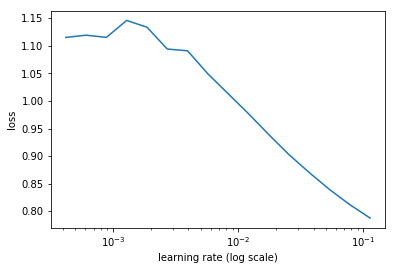

In [79]:
learn.lr_find()
learn.sched.plot()

In [24]:
learn.sched.plot_loss()

AttributeError: 'NoneType' object has no attribute 'plot_loss'

In [23]:
lr = 1e-2
learn.unfreeze()
learn.bn_freeze(True)
lrs = np.array([lr/3,lr]) / 10

In [33]:
lr = 1e-2
learn.freeze_to(1)
learn.fit(lr,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   jaccard_coef               
    0      0.362981   0.236379   0.073911  
    1      0.281541   0.162432   0.073526                  
    2      0.221547   0.125727   0.072896                    
    3      0.192567   0.121192   0.072909                  
    4      0.178957   0.119286   0.07301                   
    5      0.170069   0.111805   0.072707                    
    6      0.161835   0.104534   0.072761                   
    7      0.155754   0.103007   0.072787                  



[0.103007376, 0.07278697990112415]

In [22]:
learn.load('freezed_1')

In [34]:
learn.save('freezed_1')

In [ ]:
%time learn.fit(lrs,4,cycle_len=40,use_clr=(20,8))

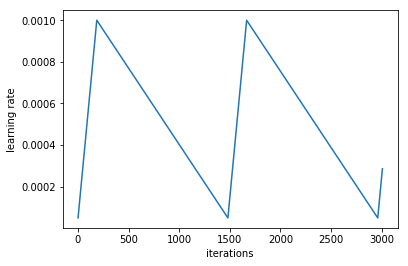

In [37]:
learn.sched.plot_lr()

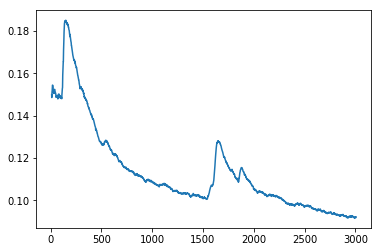

In [38]:
learn.sched.plot_loss()

In [39]:
learn.save('unfreezed_2')

In [24]:
learn.load('unfreezed_2')

In [27]:
def bool_pred(pred, thresh=0.5):
    return to_np(pred > thresh)

In [219]:
x, y = md.trn_dl.get_batch([random.randint(1, 1000) for _ in range(9)])
pred = to_np(learn.model(V(x))).squeeze()
bp = bool_pred(pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


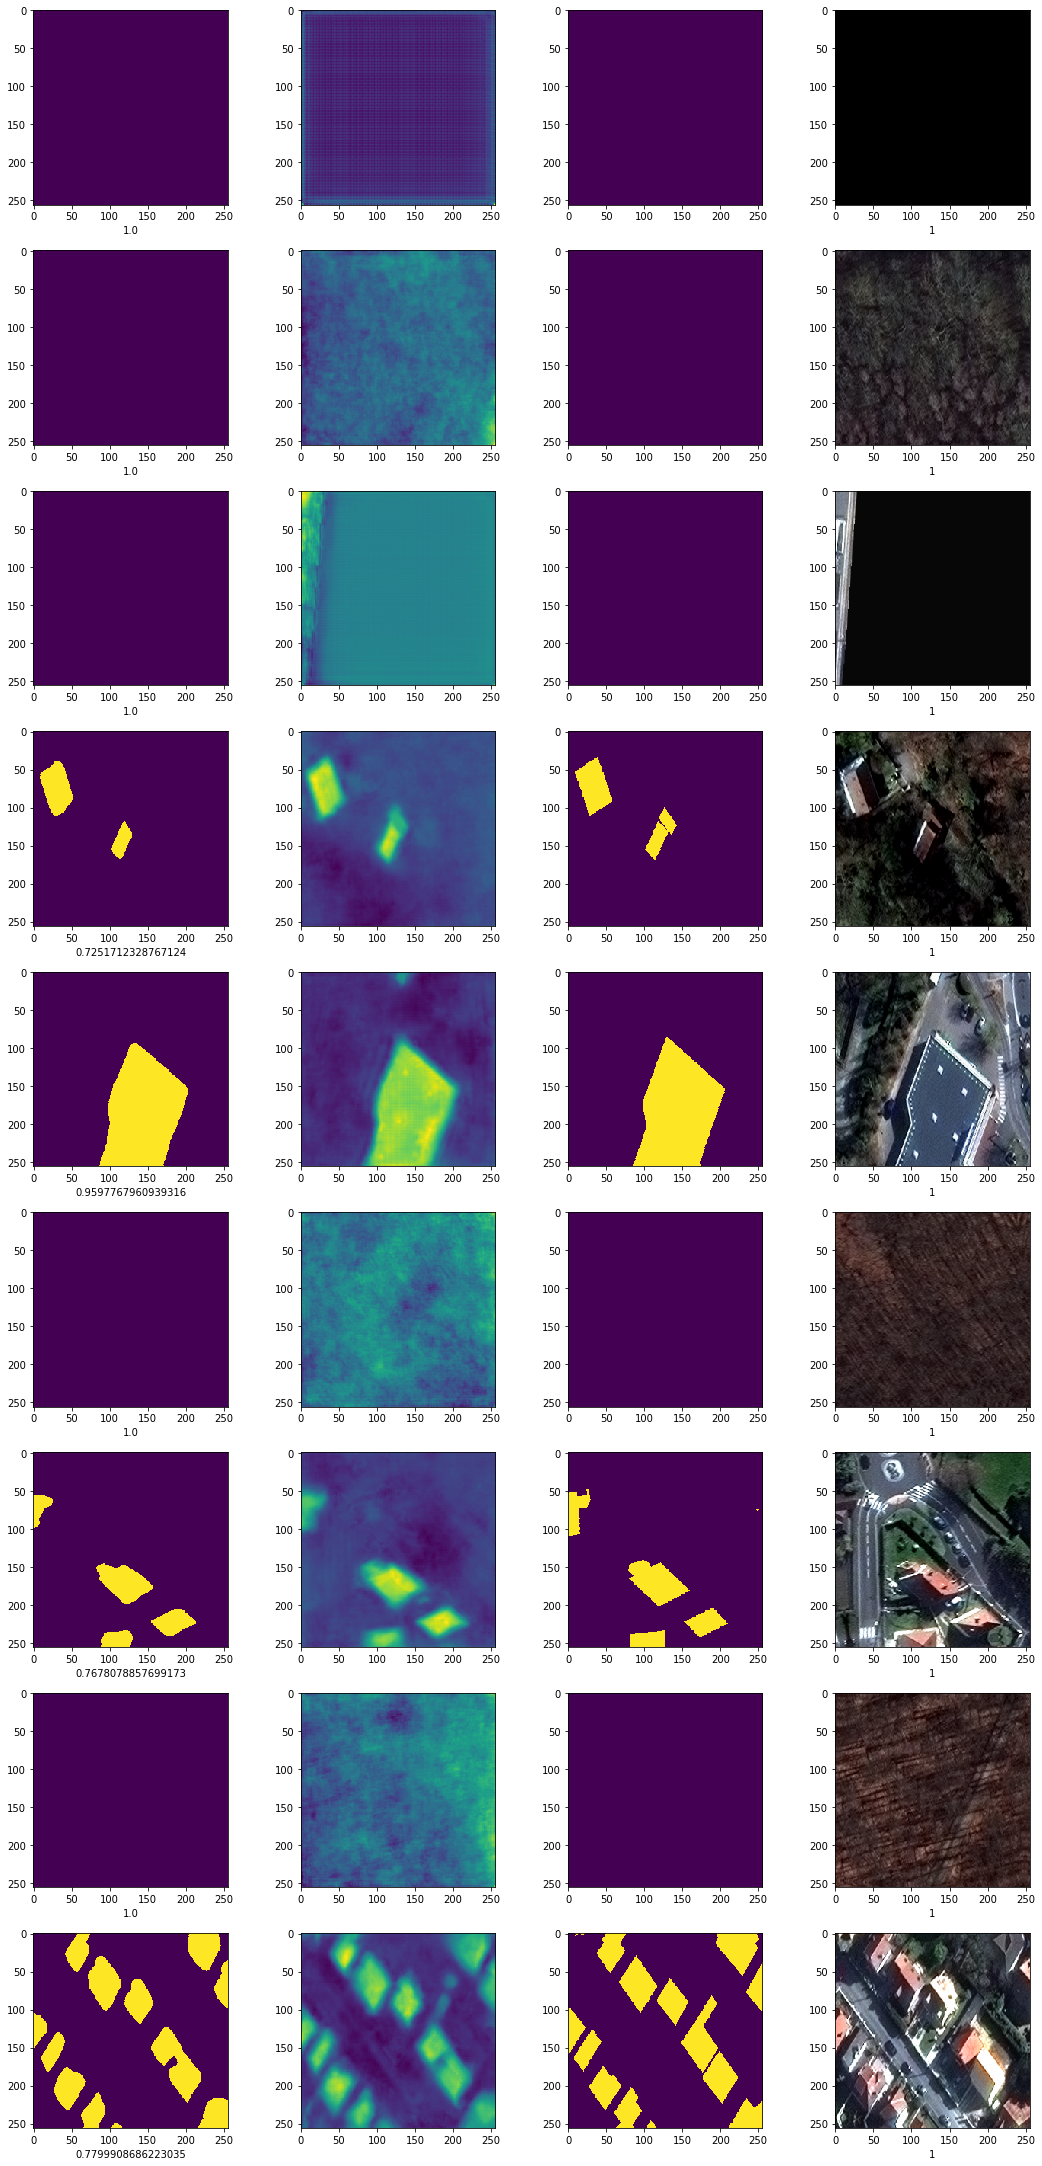

In [221]:
n_ims = 9
plt.subplots(n_ims, 4, figsize=(15,30))
for i in range(1, 1 + n_ims):
    plt.tight_layout()
    plt.subplot(n_ims, 4, i * 4)
    plt.xlabel('1')
    plt.imshow(denorm(x[i-1])[0])
    
    plt.subplot(n_ims, 4, i * 4 - 1)
    plt.imshow(y[i-1])
    
    plt.subplot(n_ims, 4, i * 4 - 2)
    plt.imshow(pred[i-1])
    
    plt.subplot(n_ims, 4, i * 4 - 3)
    bp = bool_pred(pred[i-1])
    plt.imshow(bp)
    plt.xlabel(str(jaccard_coef(y[i-1], bp)))
#     plt.imshow(to_np(learn.model(V(x[i-1][None]))).squeeze())

In [78]:
%%time
vp = learn.predict()

CPU times: user 5min 4s, sys: 59.5 s, total: 6min 3s
Wall time: 23.5 s


In [79]:
%%time
tta = learn.TTA()

CPU times: user 23min 40s, sys: 26min 7s, total: 49min 47s
Wall time: 1min 14s


In [234]:
ious = sep_iou(tta_exp, tta[1])
tta_exp = np.mean(np.exp(tta[0]), axis=0).squeeze()

In [243]:
n_ims = 9
# lowest_iou_idx = np.argpartition(ious, n_ims)
lowest_iou_idx = np.flip(np.argsort(ious), 0)

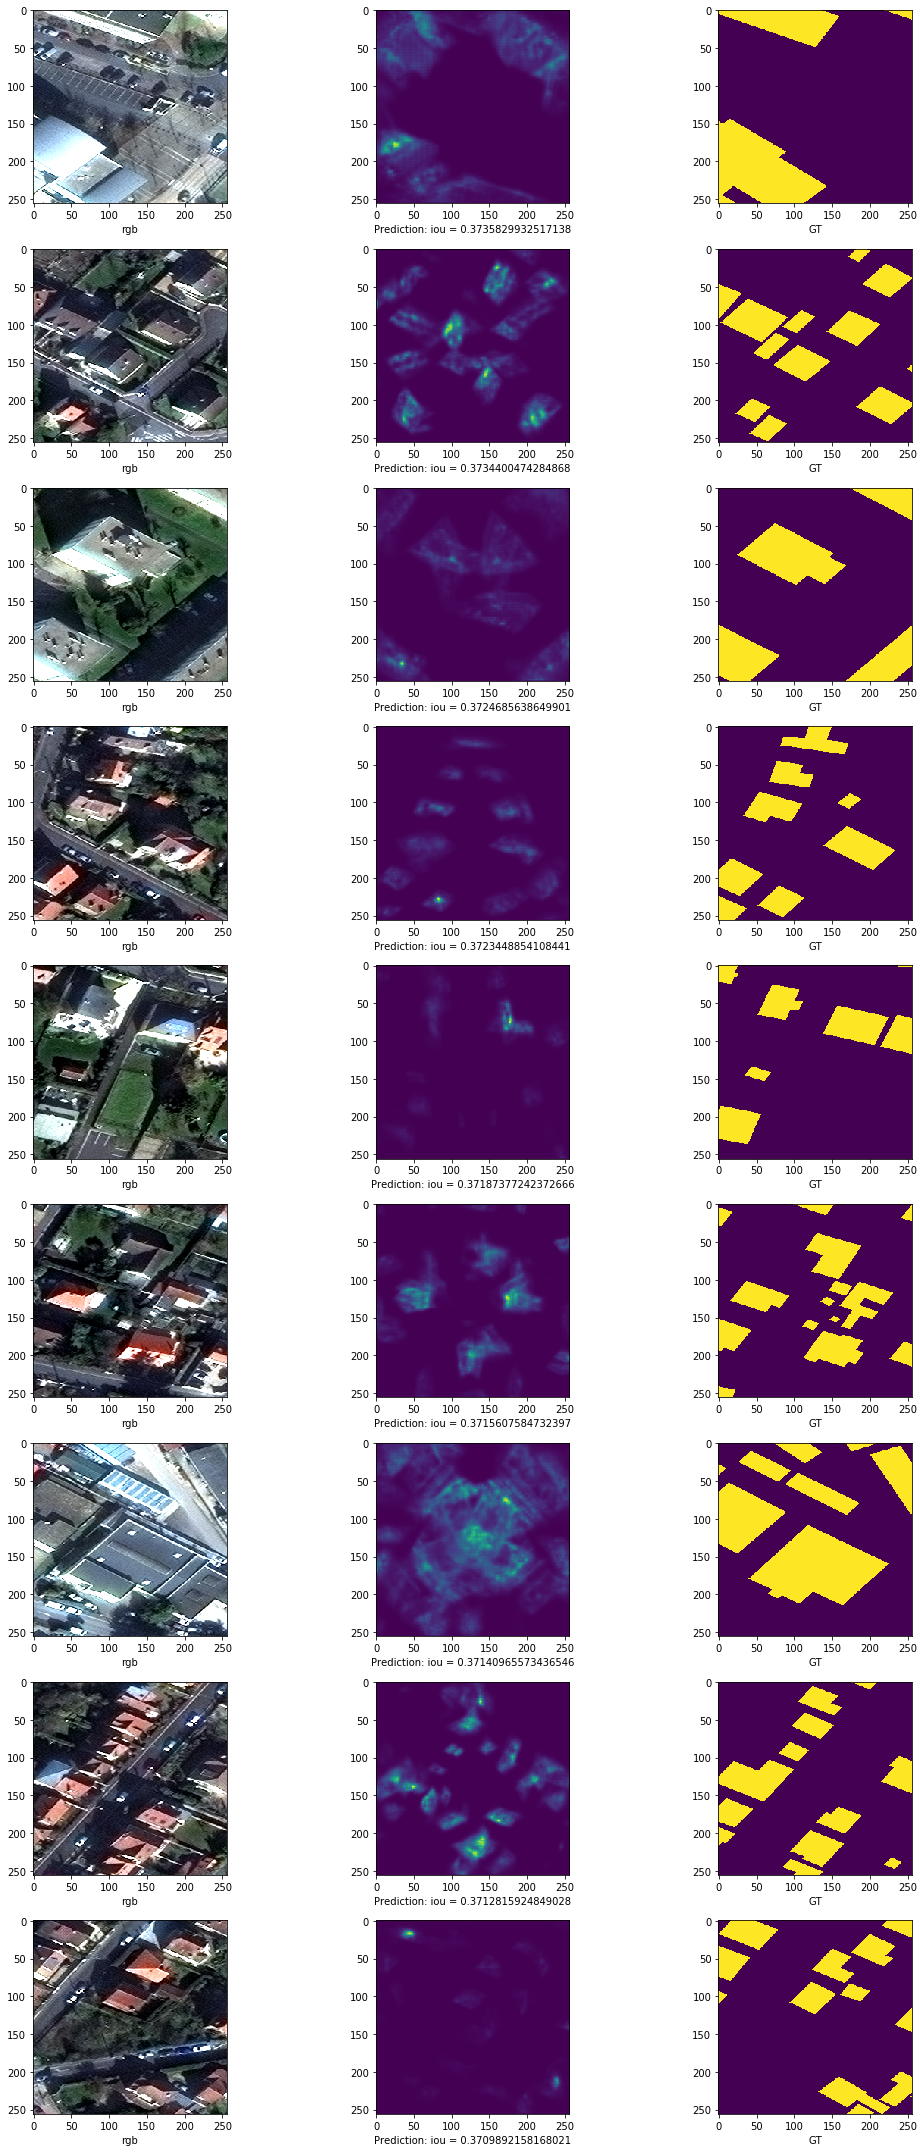

In [252]:
col = 3
plt.subplots(n_ims, 4, figsize=(15,30))
shift = 2000
for i in range(n_ims):
    x, y = md.val_dl.get_batch([lowest_iou_idx[i + shift]])
    plt.subplot(n_ims, col, i * col + 1)
    plt.xlabel('rgb')
    plt.imshow(denorm(x)[0])
    
    plt.subplot(n_ims, col, i * col + 2)
    plt.imshow(tta_exp[lowest_iou_idx[i + shift]])
    plt.xlabel('Prediction: iou = ' + str(ious[lowest_iou_idx[i + shift]]))
    
    plt.subplot(n_ims, col, i * col + 3)
    plt.imshow(tta[1][lowest_iou_idx[i + shift]])
    plt.xlabel('GT')
    
#     plt.imshow(to_np(learn.model(V(x[i-1][None]))).squeeze())
plt.tight_layout()

In [ ]:
%%time 
learn.fit(lrs,1,cycle_len=40,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

  0%|          | 0/37 [00:00<?, ?it/s]

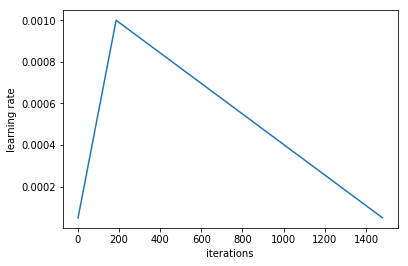

In [256]:
learn.sched.plot_lr()

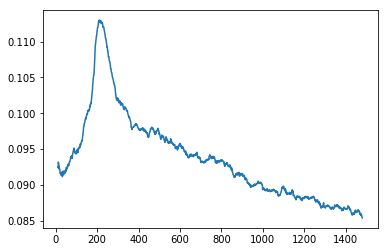

In [257]:
learn.sched.plot_loss()

In [258]:
learn.save('unfreezed_3')

In [24]:
learn.load('unfreezed_3')

In [232]:
lr = 1e-3
learn.bn_freeze(False)
lrs = np.array([lr/3,lr]) / 2

In [259]:
%%time 
learn.fit(lrs,1,cycle_len=8, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      0.09875    0.077192  
    2      0.095334   0.073236                              
    3      0.091928   0.07235                               
    4      0.090234   0.069309                              
    5      0.088675   0.070301                                
    6      0.087677   0.070422                              
    7      0.086685   0.070135                              

CPU times: user 4h 45min 52s, sys: 8h 19min 40s, total: 13h 5min 32s
Wall time: 18min 52s


[0.07013486]

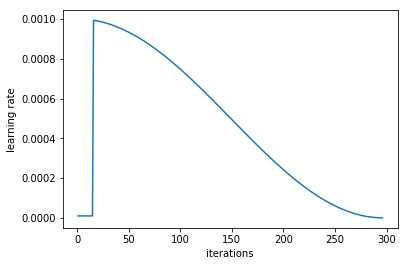

In [260]:
learn.sched.plot_lr()

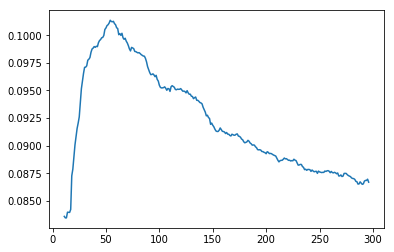

In [261]:
learn.sched.plot_loss()

In [262]:
learn.save('unfreezed_4')

In [24]:
learn.load('unfreezed_4')

In [263]:
lr = 1e-5
learn.bn_freeze(False)
lrs = np.array([lr/3,lr])

In [264]:
%%time 
learn.fit(lrs,1, cycle_len=10,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss                                
    0      0.086887   0.070306  
    1      0.085819   0.070399                              
    2      0.087324   0.070274                              
    3      0.086196   0.070427                              
    4      0.085537   0.07032                               
    5      0.085066   0.070458                              
    6      0.084903   0.070351                                
    7      0.085312   0.070206                                
    8      0.086015   0.07043                               
    9      0.086731   0.070463                                

CPU times: user 5h 28min 37s, sys: 10h 36s, total: 15h 29min 13s
Wall time: 25min 17s


[0.070462964]

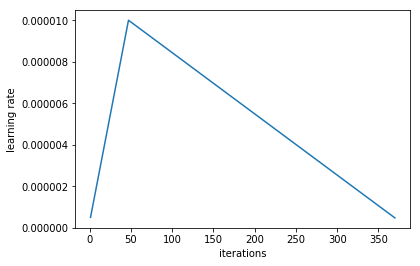

In [265]:
learn.sched.plot_lr()

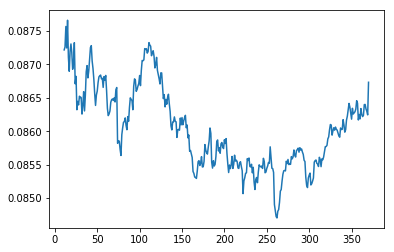

In [266]:
learn.sched.plot_loss()

In [267]:
learn.save('unfreezed_5')

In [24]:
learn.load('unfreezed_5')

In [270]:
def train(idx, epoch=1, lr=1e-6, cycle_len=8, use_clr=None):
    lrs = np.array([lr/3,lr])
    learn.fit(lrs, 1, cycle_len=cycle_len,use_clr=use_clr)
    plt.subplots(1, 2)
    plt.subplot(121)
    plt.plot(learn.sched.iterations, learn.sched.losses)
    plt.subplot(122)
    plt.plot(learn.sched.iterations, learn.sched.lrs)
    learn.save('unfreezed_' + str(idx))

In [ ]:
train(6, lr=1e-6, cycle_len=8, use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      0.086291   0.070433  
  0%|          | 0/37 [00:00<?, ?it/s]

## Ditched experiments

In [ ]:
class H5Dataset(BaseDataset):
    def __init__(self, idxs, y, transform, datapaths=datapaths, is_rgb=True):
        area_ids = [directory_name_to_area_id(datapath) for datapath in datapaths]
        self.prefixes = [area_id_to_prefix(area_id) for area_id in area_ids]
        self.is_rgb = is_rgb
        self.file_lists = [FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix) for prefix in self.prefixes]
        self.x_h5_lists = [FMT_VALTRAIN_MUL_STORE.format(prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_MUL_STORE.format(prefix) for prefix in self.prefixes]
        self.y_h5_lists = [FMT_VALTRAIN_MASK_STORE.format(prefix) for prefix in self.prefixes] +\
            [FMT_VALTEST_MASK_STORE.format(prefix) for prefix in self.prefixes]
        self.idxs = idxs # idx of trn or val. 0 ... len-1. Generate by permutation
        if transform is not None:
            super().__init__(transform)
        self.ys = y
        
        # open all files
        self.x_h5_lists_open = [tb.open_file(o) for o in self.x_h5_lists]
        self.df_lists = [pd.read_csv(o) for o in self.file_lists]

        # choose next h5 after one is exhausted
        self.ns = []
        for file_list in self.file_lists:
            df = pd.read_csv(file_list)
            self.ns.append(df.shape[0])
        self.ns = np.array(self.ns) # number of pre-crop images
        self.cum_ns = np.cumsum(self.ns * num_slice)
        
    @staticmethod
    def load_y(datapaths=datapaths):
        dummy_dataset = H5Dataset(None, None, None, datapaths=datapaths)
            
        y = []
        print('Loading masks...')
        for idx_file, df_list in enumerate(dummy_dataset.df_lists):
            with tb.open_file(dummy_dataset.y_h5_lists[idx_file]) as f:
                ys = []
                for idx_im in tqdm.tqdm(range(dummy_dataset.ns[idx_file] * num_slice), total=dummy_dataset.ns[idx_file] * num_slice):
                    slice_pos = idx_im % num_slice
                    im = np.array(f.get_node('/' + df_list.iloc[idx_im // num_slice][0] + '_' + str(slice_pos)))
                    im = np.broadcast_to(im[...,None], (256, 256, 3))
                    ys.append(im.astype('float'))
            y += ys
        return np.array(y)

        
    def get_sz(self): return self.transform.sz
    
    def get_file_idx(self,i):
        idx_file = np.argmax(i + 1 <= self.cum_ns)
        if idx_file == 0:
            idx_im = i
        else:
            idx_im = i - self.cum_ns[idx_file - 1]
        return idx_file, idx_im
    
    def get_x(self, i):
        idx_file, idx_im = self.get_file_idx(i)
        h5_list_open = self.x_h5_lists_open
        f = h5_list_open[idx_file]
        df_list = self.df_lists[idx_file]
        slice_pos = idx_im % num_slice
        
        im = np.array(f.get_node('/' + df_list.iloc[idx_im // num_slice][0] + '_' + str(slice_pos)))
        if self.is_rgb:
            # Or other bands
            im = im[...,:3]
        return im.astype('float')
    
    def get_y(self, i):
        return self.ys[i]
        
    def get_c(self): return 1
        
    def get_n(self): return self.idxs.shape[0]

#     def resize_imgs(self, targ, new_path):
#         dest = resize_imgs(self.fnames, targ, self.path, new_path)
#         return self.__class__(self.fnames, self.y, self.transform, dest)

    def denorm(self,arr):
        """Reverse the normalization done to a batch of images.

        Arguments:
            arr: of shape/size (N,3,sz,sz)
        """
        if type(arr) is not np.ndarray: arr = to_np(arr)
        if len(arr.shape)==3: arr = arr[None]
        return self.transform.denorm(np.rollaxis(arr,1,4))

    @staticmethod
    def get_ns(datapaths=datapaths):
        return H5Dataset(None, None, None, datapaths=datapaths).cum_ns[-1]

In [ ]:
# # rgb scaled
# def get_rgb_scaled(datapath):
#     area_id = directory_name_to_area_id(datapath)
#     prefix = area_id_to_prefix(area_id)
    
#     X_val = []
#     fn_im = FMT_VALTEST_IM_STORE.format(prefix)
#     with tb.open_file(fn_im, 'r') as f:
#         for idx, image_id in enumerate(df_test.ImageId.tolist()):
#             im = np.array(f.get_node('/' + image_id))
#             im = np.swapaxes(im, 0, 2)
#             im = np.swapaxes(im, 1, 2)
#             X_val.append(im)
#     X_val = np.array(X_val)

#     y_val = []
#     fn_mask = FMT_VALTEST_MASK_STORE.format(prefix)
#     with tb.open_file(fn_mask, 'r') as f:
#         for idx, image_id in enumerate(df_test.ImageId.tolist()):
#             mask = np.array(f.get_node('/' + image_id))
#             mask = (mask > 0.5).astype(np.uint8)
#             y_val.append(mask)
#     y_val = np.array(y_val)
#     y_val = y_val.reshape((-1, 1, INPUT_SIZE, INPUT_SIZE))
#     return X_val, y_val

In [ ]:
# (trn_x,trn_y), (val_x,val_y) = get_dataset(datapath)

In [ ]:
def merge_file_list():
    df = pd.DataFrame()
    # clear file
    df.to_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
    for datapath in datapaths:
        area_id = directory_name_to_area_id(datapath)        
        prefix = area_id_to_prefix(area_id)
        fn_train = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
        df_train = pd.read_csv(fn_train)
#         fn_a = FMT_VALTRAIN_IMAGELIST_PATH_ALL
#         fn_im = FMT_VALTRAIN_MUL_STORE.format(prefix)
        fn_test = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix)
        df_test = pd.read_csv(fn_test)
        df = df.append(df_train).append(df_test)
        
    df.to_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
        

In [ ]:
import traceback
def merge_im(rgb=False):
    if rgb:
        fn_store_w = FMT_VALTRAIN_IM_STORE_ALL
    else:
        fn_store_w = FMT_VALTRAIN_MUL_STORE_ALL
        
    with tb.open_file(fn_store_w, 'w') as fw:
        for datapath in datapaths:
            try:
                area_id = directory_name_to_area_id(datapath)        
                prefix = area_id_to_prefix(area_id)

                # valtrain + valtest
                for (fn_store, fn_list) in [(FMT_VALTRAIN_MUL_STORE.format(prefix), FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)),
                                         (FMT_VALTEST_MUL_STORE.format(prefix), FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix))]:
                    df_list = pd.read_csv(fn_list, index_col='ImageId')
                    with tb.open_file(fn_store, 'r') as fr:
                        for idx, image_id in tqdm.tqdm(enumerate(df_list.index), total=df_list.shape[0]):
                            for slice_pos in range(9):
                                slice_id = image_id + '_' + str(slice_pos)
                                im = np.array(fr.get_node('/' + slice_id))
                                im = np.swapaxes(im, 0, 2)
                                im = np.swapaxes(im, 1, 2)
                                if rgb:
                                    im = im[:3,...]
                                atom = tb.Atom.from_dtype(im.dtype)
                                filters = tb.Filters(complib='blosc', complevel=9)
                                ds = fw.create_carray(fw.root, slice_id, atom, im.shape,
                                                     filters=filters)
                                ds[:] = im
            except Exception as e:
                traceback.print_exc()
                print(datapath, e)

In [ ]:
# merge_file_list()
# df = pd.read_csv(FMT_VALTRAIN_IMAGELIST_PATH_ALL)
# df.head()

In [ ]:
# merge_im(True)
# merge_im(False) # Too big